In [1]:
import pickle
import numpy as np
from pathlib import Path
import math
import matplotlib.pyplot as plt

from pyriodic.circular import Circular
from pyriodic.viz import CircPlot
from pyriodic.permutation import permutation_test_against_surrogate

from pyriodic.surrogate import surrogate_shuffle_breath_cycles

## Single-level analysis


In [2]:
data_path = Path("../../data/respiration/intermediate")
subj_id = "0019"
file_path = data_path / f"participant_{subj_id}_preproc.pkl"

with open(file_path, 'rb') as f:
            data = pickle.load(f)

circ = data["circ"]
PA = data["phase_angles"]
circ_target = circ["target"]

rejected_indices = data["rejected_indices"]
events_samples = data["event_samples"]

# remove rejected indices from the the event samples
events_samples = [event for event in events_samples if event not in rejected_indices]
labels = circ.labels
target_event_samples = [samp for samp, label in zip(events_samples, labels) if "target" in label]

In [3]:
surr_samples = surrogate_shuffle_breath_cycles(PA, target_event_samples, n_surrogate=2000)

In [4]:
# Run permutation test
obs_stat, pval = permutation_test_against_surrogate(
    circ_target.data,
    surrogate_samples=surr_samples,
    alternative="greater",
    n_permutations = 10000,
)

p val: 9.999000099990002e-05, observed stat: 3999998.000, mean null stat: 1999895.148


Let's visually compare the observed phase angles of the target stimuli to a null distribution of phase angles drawn from the full respiratory cycle by plotting the mean resultant vector length and the mean angle for both the observed target phase angles and a sample of null phase angles.

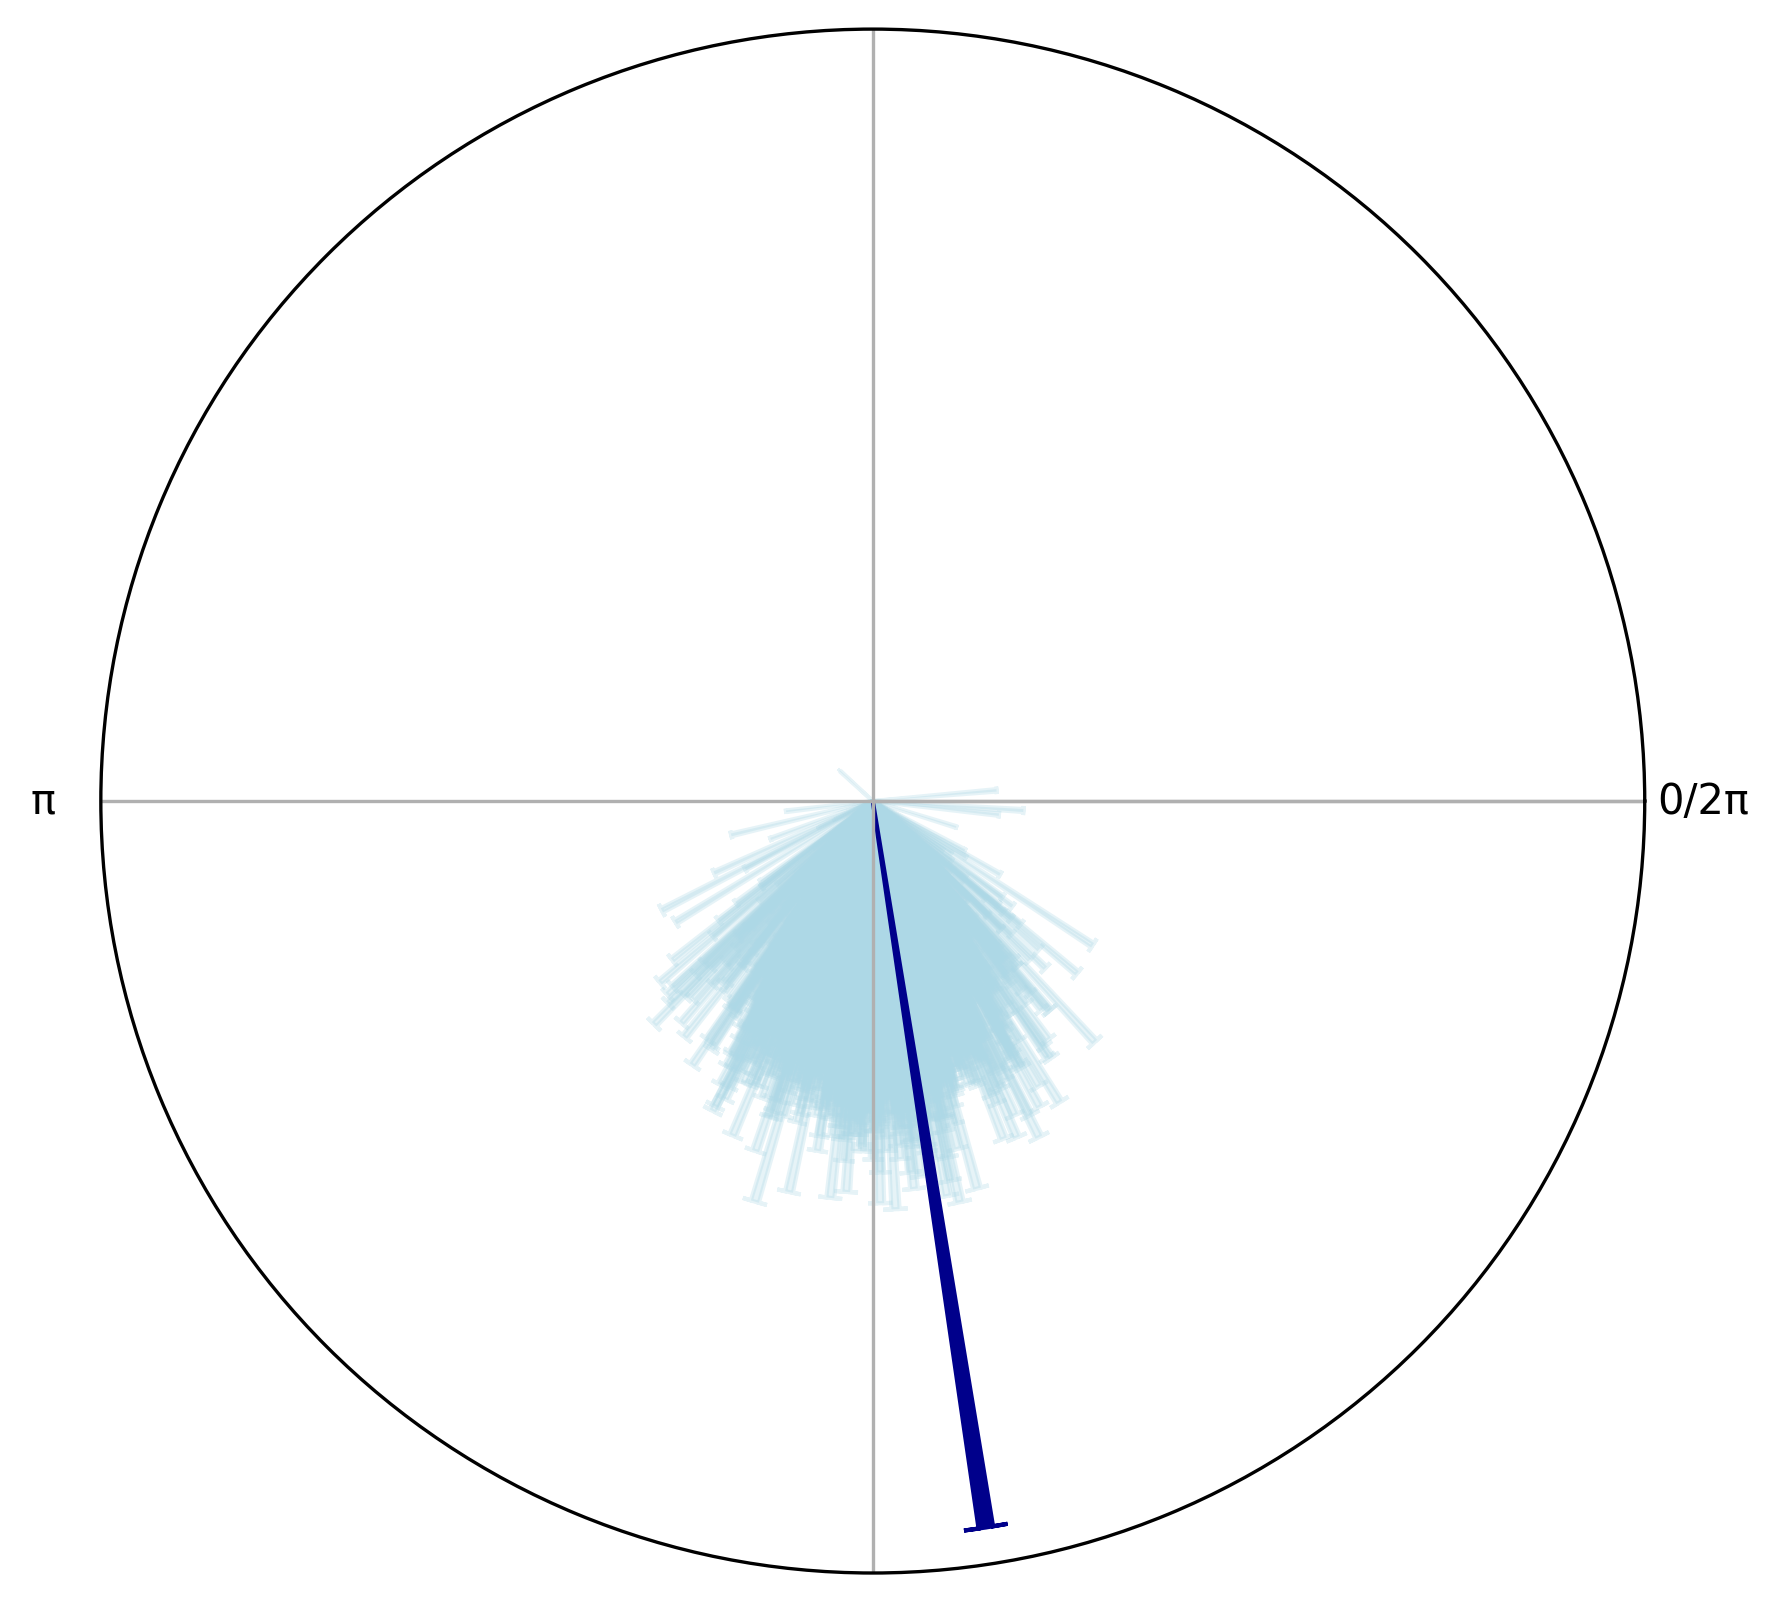

In [5]:
# make a circular object with the null_samples for plotting
circ_surr = Circular.from_multiple(
    [Circular(samp, labels=[i]*len(samp)) for i, samp in enumerate(surr_samples)]
)

circplot_surr = CircPlot(circ_surr)
circplot_surr.add_circular_mean(color = "lightblue", alpha = 0.3)
circplot_surr.add_arrows(
    np.array([circ_target.mean()]),
    np.array([circ_target.r()]),
    color="darkblue"
)

plt.tight_layout()

We can see the length of the resultant vector for the target phase angles is larger than the means from the surrogate distribution samples, indicating that the target phase angles are more aligned with a specific phase of the respiratory cycle than would be expected by chance as found using the permutation test. 

## Group-level analysis

In [6]:
circulars = {}
pas = {}
rejected_indices = {}
events_samples = {}


for file_path in data_path.iterdir(): 
    subj_id = file_path.name.split("_")[1]
    with open(file_path, 'rb') as f:
            data = pickle.load(f)

    circulars[subj_id] = data["circ"]
    pas[subj_id] = data["phase_angles"]
    rejected_indices[subj_id] = data["rejected_indices"]
    events_samples[subj_id] = data["event_samples"]



In [ ]:
rng = np.random.default_rng(seed=42)

results = {}

for subj_id in circulars:
    observed = circulars[subj_id]["target"]
    pa = pas[subj_id]

    rejected_idx = rejected_indices[subj_id]
    events_samp = events_samples[subj_id]

    # remove rejected indices from the the event samples
    events_samp = [event for event in events_samp if event not in rejected_idx]
    labels = circ.labels

    # find the event samples for the target events in circ
    target_event_samples = [samp for samp, label in zip(events_samp, labels) if "target" in label]

    surr_samples = surrogate_shuffle_breath_cycles(pa, target_event_samples, n_surrogate=2000)

    # Run participant-level permutation test
    obs_stat, pval, obs_vs_surr, surr_vs_surr = permutation_test_against_surrogate(
        observed.data,
        surrogate_samples=surr_samples,
        alternative="greater",
        n_permutations = 10000,
        return_obs_and_surr_stats=True
    )
    # per-participant summary stats (means of distributions)
    circ_surr_samples = Circular.from_multiple(
        [Circular(samp, labels=[i]*len(samp)) for i, samp in enumerate(surr_samples)]
    )

    results[subj_id] = {
        "obs_vs_surr": obs_vs_surr,
        "surr_vs_surr": surr_vs_surr,
        "pval": pval,
        "null_samples": circ_surr_samples
        }
    

p val: 9.999000099990002e-05, observed stat: 3993263.000, mean null stat: 2000181.432
p val: 9.999000099990002e-05, observed stat: 3989769.000, mean null stat: 2000106.301
p val: 9.999000099990002e-05, observed stat: 3997329.000, mean null stat: 2000246.982
p val: 9.999000099990002e-05, observed stat: 4000000.000, mean null stat: 1999452.340
p val: 9.999000099990002e-05, observed stat: 3974340.000, mean null stat: 1999741.353
p val: 9.999000099990002e-05, observed stat: 3660550.000, mean null stat: 1999974.135
p val: 9.999000099990002e-05, observed stat: 3602984.000, mean null stat: 2000139.672
p val: 9.999000099990002e-05, observed stat: 2415494.000, mean null stat: 1999989.829
p val: 9.999000099990002e-05, observed stat: 3965711.000, mean null stat: 2000090.347
p val: 9.999000099990002e-05, observed stat: 3457135.000, mean null stat: 2000137.747
p val: 9.999000099990002e-05, observed stat: 3797769.000, mean null stat: 1999979.950
p val: 9.999000099990002e-05, observed stat: 3999999.0

In [ ]:
from pyriodic.permutation import permutation_test_within_units
surr = [results[subj_id]["surr_vs_surr"] for subj_id in results]
obs = [results[subj_id]["obs_vs_surr"] for subj_id in results]

group_obs_stat, group_pval, group_null = permutation_test_within_units(
    data1=obs,
    data2=surr,
    n_permutations=10000,
    alternative="greater",
    verbose=True,
    return_null_distribution=True
)

Generating null distribution:   0%|          | 0/10000 [00:00<?, ?it/s]

Observed statistic = 0.2914, p = 0.0001


### Is this effect consistent across all participants?

In [ ]:
n_subjects = len(results)

n_cols = 4 
n_rows = math.ceil(n_subjects / n_cols)

fig, axes = plt.subplots(
    n_rows, n_cols, 
    dpi = 300, 
    figsize = (n_cols*3, n_rows*3), 
    subplot_kw={'projection': 'polar'},
    sharex=True,
    sharey=True
)

axes = axes.flatten()

for i, subj_id in enumerate(circulars):
    tmp_result = results[subj_id]
    circ_obs_target = circulars[subj_id]["target"]
    circ_null = tmp_result["null_samples"]
    
    
    ax = axes[i]
    tmp_plot = CircPlot(circ_null, ax=ax)
    tmp_plot.add_circular_mean(alpha = 0.1, color = "lightblue")
    tmp_plot.add_arrows([circ_obs_target.mean()], [circ_obs_target.r()], label = "Observed", color = "darkblue")

    ax.set_title(f"{subj_id}, pval = {tmp_result['pval'].round(6)}", fontsize=8)

# Hide unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis("off")


plt.tight_layout()
